## Felzenszwalb and Huttenlocher 

[Efficient graph-based image segmentation, Felzenszwalb, P.F. and Huttenlocher, D.P. International Journal of Computer Vision, 2004](https://link.springer.com/article/10.1023/B:VISI.0000022288.19776.77)

Given an undirected graph $G = (V, E)$, with each edge $(v_i, v_j)$ having the corresponding weight $w(v_i, v_j)$ that corresponds to the distance btween the two nodes, we want to generate a degmentatio $S$ in which each component corresponds to a connected region of the graph $G' = (V, E')$, $E' \subseteq E$. In general, edges in connected regions have smaller weights and edges between different components have bigger weights. 

To determine if there is a boundary between two components $C_1$ and $C_2$ we use the predicate $D$. It compares inter-component differences with intra-component differences.

The internal difference is: 
$$ Int(C) = \max_{e \in MST(C, E)}w(e)$$
With MST designationg the Minimum spanning tree of the component

The difference between to components is: 
$$Dif(C_1, C_2) = \min_{v_i \in C_1, v_j \in C_2,(v_i,v_j)\in E}w(v_i, v_j)$$
If there is no edge connecting the components, $Dif(C_1, C_2) = \infty$.

$ D(C_1),(C_2) = $
- true   if $Dif(C_1, C_2) > MInt(C_1, C_2)$
- false  otherwise

With 

$$ MInt(C_1, C_2) = \min(Int(C_1) + \tau(C_1), Int(C_2) + \tau(C_2)) $$

And, 
$$\tau(C) = \frac{k}{|C|}$$
Where $k$ sets a scale of observation, in practice (and is actually called *scale* in skimage). However it is not a minimum component size.

The algorithm goes:

0. Sort $E$ into $\pi = (o_1,\dots,o_m)$ by non-decreasing order
1. $S^0$ where each node $v_i$ is in the component $C_i$
2. For $q \in [1,\dots,m]$, compute $S^q$ from $S^{q-1}$:
    1. With $o_q = (v_i, v_j)$, get $C_i^{q-1}$ so that $v_i \in C_i^{q-1}$ and $C_i^{q-1}$ so that $v_j \in C_j^{q-1}$
    2. If $C_i^{q-1} = C_j^{q-1}$, continue
    3. If $w(o_q) \leq MInt(C_i^{q-1},C_j^{q-1})$, $S^q = C_i \cup_{S^{q-1}} C_j$, else $S^q = S^{q-1}$



### Notes on making it differentiable

Set operations that will be required:
- merge($C_i, C_j, S^{q-1}$) $\rightarrow S^q$
- get_component($v_i$) $\rightarrow C_i, v_i \in C_i$

Changing the algorithm to

0. $O = E$ 
1. $S^0$ where each node $v_i$ is in the component $C_i$
2. For $q \in [1,\dots,m]$, compute $S^q$ from $S^{q-1}$: 

    0. $o_q = \argmax_{o \in O} w(o)$, $O \leftarrow O - o_q$
    1. With $o_q = (v_i, v_j)$, get $C_i^{q-1}$ so that $v_i \in C_i^{q-1}$ and $C_i^{q-1}$ so that $v_j \in C_j^{q-1}$
    2. If $C_i^{q-1} = C_j^{q-1}$, continue
    3. If $w(o_q) \leq MInt(C_i^{q-1},C_j^{q-1})$, $S^q = C_i \cup_{S^{q-1}} C_j$, else $S^q = S^{q-1}$

Can make the sorting differentiable w/ the softmax relaxation of argmax


Calculate the probability of $C_i$ and $C_j$ belonging to the same component instead of choosing whether to merge or not based on the $w(o_q) \leq MInt(C_i^{q-1},C_j^{q-1})$ inequality.

Option: 
$$ w(o_q) \leq MInt(C_i^{q-1},C_j^{q-1}) $$
$$\frac{w(o_q)}{w(o_q)} \leq \frac{MInt(C_i^{q-1},C_j^{q-1})}{w(o_q)}$$
$$1 \leq \frac{MInt(C_i^{q-1},C_j^{q-1})}{w(o_q)}$$
$$\frac{MInt(C_i^{q-1},C_j^{q-1})}{w(o_q)} \geq 1$$
$$P(C_i^{q-1},C_j^{q-1} | S^{q-1}) = sigmoid\left(\frac{MInt(C_i^{q-1},C_j^{q-1})}{w(o_q)}-1\right)$$

If the scale factor is a learneable paramenter, or even if $\tau(C_i)$ is a learnable function maybe it can learn to compensate for the sigmoid?

If so, merge($C_i, C_j, S^{q-1}$) will have to account for the probability 

## Implementations 

In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
from skimage.data import coffee, astronaut
from skimage.util import img_as_float
from skimage.transform import resize_local_mean

In [2]:
img = astronaut()
img = resize_local_mean(img, (128, 128))

In [5]:
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

def img_as_graph(img):
    img_tensor = torch.tensor(img_as_float(img))
    height, width = img_tensor.shape[:2]

    node_index   = torch.arange(width * height).reshape(width, height)
    down_edges   = torch.column_stack((node_index[1:, :].ravel(), node_index[:height-1, :].ravel()))
    right_edges  = torch.column_stack((node_index[:, 1:].ravel(), node_index[:, :width-1].ravel()))
    dright_edges = torch.column_stack([node_index[1:, 1:].ravel(), node_index[:height-1, :width-1].ravel()])
    uright_edges = torch.column_stack([node_index[:height-1, 1:].ravel(), node_index[1:, :width-1].ravel()])
    edge_index = torch.vstack((right_edges, down_edges, dright_edges, uright_edges)).T

    p_width, p_height = 1./width, 1./height
    pos_x, pos_y = np.meshgrid(np.linspace(p_width/2, 1 - p_width, width), 
                               np.linspace(p_height/2, 1 - p_height, height))
    pos_x = torch.tensor(pos_x).flatten()
    pos_y = torch.tensor(pos_y).flatten()
    pos = torch.stack((pos_x, pos_y)).T

    x = img_tensor.flatten(end_dim=-2)
    x = torch.cat((x, pos), dim=1)

    return Data(x=x, edge_index=edge_index, pos=pos)

def show_graph(g, colors=None):
    g_nx = to_networkx(g)

    pos = None
    if g.pos is not None:
        N = g.pos.shape[0]
        pos = g.pos 
        pos[:, 1] = 1 - pos[:, 1]
        pos = dict(zip(np.arange(N), pos))
    
    color = g.x[:, :3]
    nx.draw(g_nx, pos, node_color=color)

### skimage implementation

In [452]:
from skimage.segmentation import felzenszwalb, mark_boundaries

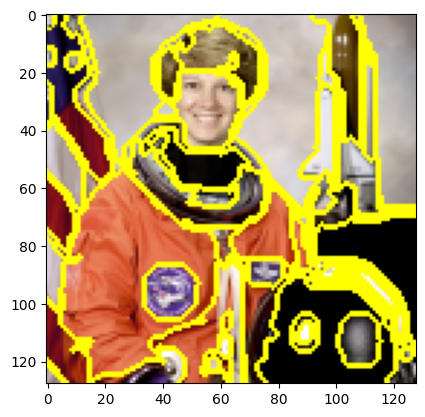

In [10]:
segments = felzenszwalb(img, scale=300, sigma=0.8, min_size=10)
plt.imshow(mark_boundaries(img, segments))

### Differentiable version with pytorch...

Based on [skimage's implementation](https://github.com/scikit-image/scikit-image/blob/main/skimage/segmentation/_felzenszwalb_cy.pyx).

In [3]:
import torch
import torch.nn as nn
# from torchviz import make_dot

In [6]:
g = img_as_graph(img)
g
# show_graph(g)
# plt.draw()

Data(x=[16384, 5], edge_index=[2, 64770], pos=[16384, 2])

In [8]:
class Faslzenszwalb(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.scale = 300
        self.device = 'cuda'

    def forward(self, x, edge_index):
        num_nodes = x.shape[-1]
        if not torch.is_sparse(edge_index):
            num_edges = edge_index.shape[0]
            edge_index = torch.sparse_coo_tensor(
                indices=edge_index.T, 
                values=torch.ones(num_edges), 
                size=(num_edges, num_edges))
        edge_weight = self.compute_weights(x, edge_index)
        edge_queue = torch.argsort(edge_weight)
        s = self.get_s0(num_nodes).to(device=self.device)
        int_d = torch.zeros(num_nodes) # internal differences 
        sizes = torch.ones(num_nodes)  # segment sizes

        aa = 10
        for e in edge_queue:
            vi, vj = edge_index[e]
            ci = self.get_segment(vi, s)
            cj = self.get_segment(vj, s)

            if ci == cj:
                continue 
            
            inti = int_d[ci] + self.scale / sizes[ci]
            intj = int_d[cj] + self.scale / sizes[cj]

            if edge_weight[e] < torch.min(inti, intj):
                s = self.merge_segments(ci, cj, s)
                sizes[ci] += sizes[cj]
                int_d[cj] = edge_weight[e]
            aa -= 1
            if aa == 0:
                break
        s_encode = torch.vmap(s.mv)
        x_out = s_encode(x) 
        edge_index_out = edge_index 
        edge_weight_out = edge_weight
        return s, x_out, edge_index_out, edge_weight_out
    
    def compute_weights(self, x, edge_index):
        
    
    def get_s0(self, num_nodes):
        indices = np.array([np.arange(num_nodes), np.arange(num_nodes)], dtype=np.int64)
        values  = np.ones(num_nodes)
        return torch.sparse_coo_tensor(indices, values, (num_nodes, num_nodes))

    def get_segment(self, v, ss):
        c = torch.select(ss, 0, v)
        c = c.coalesce().indices().flatten().min()
        return c

    def merge_segments(self, ci, cj, ss):
        cj_segment = torch.select(ss, 1, cj).coalesce()

        cj_indices = cj_segment.indices().flatten()
        indices_v = torch.concat([cj_indices, cj_indices]) # nodes
        indices_c = torch.concat([ci * torch.ones_like(cj_indices), cj * torch.ones_like(cj_indices)]) # segments
        indices = torch.stack([indices_v, indices_c])

        cj_values = cj_segment.values()
        values = torch.concat([cj_values, -1*cj_values])

        offset = torch.sparse_coo_tensor(indices, values, ss.size())
        return ss + offset 
            

IndentationError: expected an indented block after function definition on line 46 (1471701783.py, line 49)

In [69]:
device = 'cuda'
img_tensor = torch.tensor(img_as_float(img))

height, width = img_tensor.shape[:2]
down_cost   = torch.sqrt(torch.sum((img_tensor[1:, :, :] - img_tensor[:height-1, :, :]) ** 2, dim=-1))
right_cost  = torch.sqrt(torch.sum((img_tensor[:, 1:, :] - img_tensor[:, :width-1, :]) ** 2, dim=-1))
edge_weights = torch.hstack([right_cost.ravel(), down_cost.ravel()])
S = torch.arange(width * height).reshape(width, height)
down_edges   = torch.column_stack((S[1:, :].ravel(), S[:height-1, :].ravel()))
right_edges  = torch.column_stack((S[:, 1:].ravel(), S[:, :width-1].ravel()))
edge_index = torch.vstack((right_edges, down_edges))

x = img_tensor.T.flatten(start_dim=1).to(device=device).requires_grad_(True)
edge_index = edge_index.to(device=device)
edge_weights = edge_weights.to(device=device)


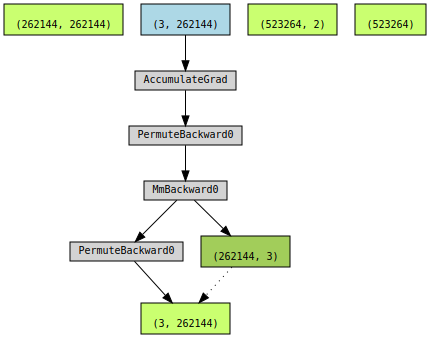

In [120]:
f = Faslzenszwalb().to(device=device)
out = f(x, edge_index, edge_weights)

make_dot(out, params=dict(f.named_parameters()))

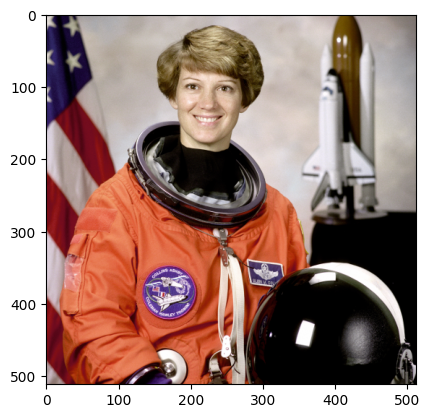

In [19]:
img_tensor = torch.tensor(img_as_float(img), requires_grad=True)
with torch.no_grad():
    plt.imshow(img_tensor.detach().numpy())
img_tensor = img_tensor.cuda()


Computing edge weights w/ 8 connectivity

In [24]:
height, width = img_tensor.shape[:2]

down_cost   = torch.sqrt(torch.sum((img_tensor[1:, :, :] - img_tensor[:height-1, :, :]) ** 2, dim=-1))
right_cost  = torch.sqrt(torch.sum((img_tensor[:, 1:, :] - img_tensor[:, :width-1, :]) ** 2, dim=-1))
# dright_cost = torch.sqrt(torch.sum((img_tensor[1:, 1:, :] - img_tensor[:height-1, :width-1, :]) ** 2, dim=-1))
# uright_cost = torch.sqrt(torch.sum((img_tensor[1:, :width-1, :] - img_tensor[:height-1, 1:, :]) ** 2, dim=-1))
# costs = torch.hstack([right_cost.ravel(), down_cost.ravel(), dright_cost.ravel(), uright_cost.ravel()])
costs = torch.hstack([right_cost.ravel(), down_cost.ravel()]).cuda()

In [25]:
print(costs)
print(costs.shape)

tensor([0.2686, 0.2667, 0.0474,  ..., 0.0039, 0.0000, 0.0000], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
torch.Size([523264])


Computing the graphs edges $E$ and $S_0$ 

In [26]:
S = torch.arange(width * height).reshape(width, height).cuda()
S

tensor([[     0,      1,      2,  ...,    509,    510,    511],
        [   512,    513,    514,  ...,   1021,   1022,   1023],
        [  1024,   1025,   1026,  ...,   1533,   1534,   1535],
        ...,
        [260608, 260609, 260610,  ..., 261117, 261118, 261119],
        [261120, 261121, 261122,  ..., 261629, 261630, 261631],
        [261632, 261633, 261634,  ..., 262141, 262142, 262143]],
       device='cuda:0')

In [27]:
down_edges   = torch.column_stack((S[1:, :].ravel(), S[:height-1, :].ravel()))
right_edges  = torch.column_stack((S[:, 1:].ravel(), S[:, :width-1].ravel()))
# dright_edges = torch.column_stack((S[1:, 1:].ravel(), S[:height-1, :width-1].ravel()))
# uright_edges = torch.column_stack((S[:height-1, 1:].ravel(), S[1:, :width-1].ravel()))
# edges = torch.vstack((right_edges, down_edges, dright_edges, uright_edges))
edges = torch.vstack((right_edges, down_edges))
edges

tensor([[     1,      0],
        [     2,      1],
        [     3,      2],
        ...,
        [262141, 261629],
        [262142, 261630],
        [262143, 261631]], device='cuda:0')

In [28]:
edge_queue = torch.argsort(costs)
edge_queue
edges = edges[edge_queue]
costs = costs[edge_queue]
segment_size = torch.ones(width * height, dtype=torch.int8)

In [29]:
Int = torch.zeros(width * height).cuda() # Internal differences 
Int

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

#### 1. Sparse matrices

$S$ will be a $(H*W) \times (H*W)$ matrix. Basically the same idea as a sparse edge matrix. dim = 1 represents the segments $C$, dim = 0 the nodes $V$ that compose the segment.

In [94]:
indices = np.array([np.arange(width*height), np.arange(width*height)], dtype=np.int64)
values  = np.ones(width * height)
print(indices, values)

Ss = torch.sparse_coo_tensor(indices, values, (width*height, width*height), requires_grad=True, device='cuda')
Ss

[[     0      1      2 ... 262141 262142 262143]
 [     0      1      2 ... 262141 262142 262143]] [1. 1. 1. ... 1. 1. 1.]


tensor(indices=tensor([[     0,      1,      2,  ..., 262141, 262142, 262143],
                       [     0,      1,      2,  ..., 262141, 262142, 262143]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       device='cuda:0', size=(262144, 262144), nnz=262144, dtype=torch.float64,
       layout=torch.sparse_coo, requires_grad=True)

Merge operation of segments $C_i$ and $C_j$ into $C_i$:
1. Select the vector $c_j$ that corresponds to $S[j, :]$
2. $c_i = c_i + c_j$
3. $c_j = c_j - c_j$

In [95]:
ci_idx, cj_idx = 0, 2
off_idx = ci_idx - cj_idx

cj = torch.select(Ss, 1, cj_idx).coalesce()

cj_indices = cj.indices()
top = torch.concat([torch.ones_like(cj_indices).flatten() * ci_idx, torch.ones_like(cj_indices).flatten() * cj_idx])
bottom = torch.concat([cj_indices.flatten(), cj_indices.flatten()])
indices = torch.stack([bottom, top])

cj_values = cj.values()
values = torch.concat([cj_values, -1 * cj_values])
print(values)

off = torch.sparse_coo_tensor(indices, values, (width*height, width*height))
print(off)

Ss = Ss + off
Ss = Ss.coalesce()
Ss

tensor([ 1., -1.], device='cuda:0', dtype=torch.float64,
       grad_fn=<CatBackward0>)
tensor(indices=tensor([[2, 2],
                       [0, 2]]),
       values=tensor([ 1., -1.]),
       device='cuda:0', size=(262144, 262144), nnz=2, dtype=torch.float64,
       layout=torch.sparse_coo,
       grad_fn=<SparseCooTensorWithDimsAndTensorsBackward0>)


tensor(indices=tensor([[     0,      1,      2,  ..., 262141, 262142, 262143],
                       [     0,      1,      0,  ..., 262141, 262142, 262143]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       device='cuda:0', size=(262144, 262144), nnz=262145, dtype=torch.float64,
       layout=torch.sparse_coo, grad_fn=<CoalesceBackward0>)

In [103]:
cj.values()

tensor([1.], device='cuda:0', dtype=torch.float64, grad_fn=<ValuesBackward0>)

In [34]:
def merge_segments(ci, cj, Ss):
    cj_segment = torch.select(Ss, 1, cj).coalesce()

    cj_indices = cj_segment.indices().flatten()
    indices_v = torch.concat([cj_indices, cj_indices]) # nodes
    indices_c = torch.concat([ci * torch.ones_like(cj_indices), cj * torch.ones_like(cj_indices)]) # segments
    indices = torch.stack([indices_v, indices_c])

    cj_values = cj_segment.values()
    values = torch.concat([cj_values, -1*cj_values])

    offset = torch.sparse_coo_tensor(indices, values, Ss.size())
    return Ss + offset 

Finding the segment $C_i$ of the node $v_i$

In [17]:
vi_idx = 1
vi = torch.select(Ss, 0, vi_idx)
print(vi)
vi = vi.coalesce()
ci = torch.argmin(vi.indices().flatten())
ci

tensor(indices=tensor([[1]]),
       values=tensor([1.]),
       size=(262144,), nnz=1, dtype=torch.float64, layout=torch.sparse_coo,
       grad_fn=<SelectBackward0>)


tensor(0)

In [18]:
indices = Ss.coalesce().indices()
vi = 2
vi_indices = indices[1, torch.argwhere(indices[0] == vi)].min()
vi_indices

tensor(0)

In [35]:
def get_segment(vi, Ss):
    vi_segment = torch.select(Ss, 0, vi).coalesce()
    ci = vi_segment.indices().flatten().min()
    return ci

In [70]:
def get_segment(vi, Ss):
    return 1

Getting the segmentation $S$ as a $H \times W$ vector

In [20]:
Ss = Ss.coalesce()
Ss.indices()[:100, :100]

# S = indices[torch.argwhere(Ss.values())]
indices = Ss.indices()
C = indices[1][torch.argwhere(Ss.values())].flatten()
C[:100]

tensor([ 0,  1,  0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [21]:
Ss

tensor(indices=tensor([[     0,      1,      2,  ..., 262141, 262142, 262143],
                       [     0,      1,      0,  ..., 262141, 262142, 262143]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(262144, 262144), nnz=262145, dtype=torch.float64,
       layout=torch.sparse_coo, grad_fn=<CoalesceBackward0>)

#### 2. Normal matrices

In [18]:
Ss = torch.eye(width * height)

Ss

RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 274877906944 bytes. Error code 12 (Cannot allocate memory)

:(

#### 3. Probabilistic sparse matrices

In [7]:
device = 'cuda'
# device = 'cpu'

g = g.to(device=device) 

m = g.edge_index.shape[-1]
n = g.x.shape[0]

print(g)

Data(x=[16384, 5], edge_index=[2, 64770], pos=[16384, 2])


##### Preamble:
- Create $S^0$
- Compute edge weights 
- Create edge queue 

For $S^0$: 
- rows (dim 0) $\rightarrow$ nodes 
- cols (dim 1) $\rightarrow$ segments

In [489]:
S_idx = torch.tensor(np.array([np.arange(n), np.arange(n)], dtype=np.int64), device=device)
S_val  = torch.tensor(np.ones(n), device=device)

In [555]:
S = torch.sparse_coo_tensor(S_idx, S_val, (n,n)).coalesce()

In [509]:
def compute_edge_weights(g):
    vi, vj = g.x[g.edge_index[0]], g.x[g.edge_index[1]]
    return torch.norm(vi - vj, dim=1)

edge_weights = compute_edge_weights(g)
edge_weights, edge_weights.shape

(tensor([0.0466, 0.2163, 0.7224,  ..., 0.1427, 0.1972, 0.1605], device='cuda:0',
        dtype=torch.float64),
 torch.Size([64770]))

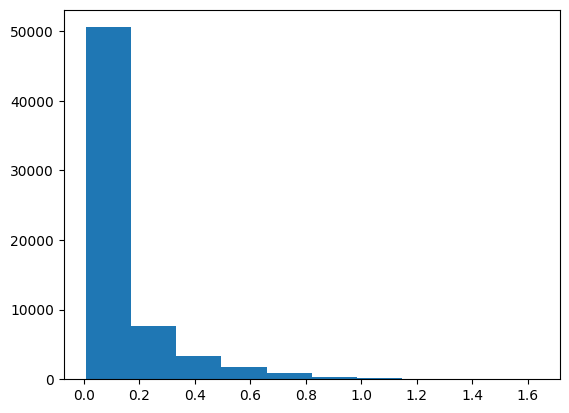

In [511]:
plt.hist(edge_weights.to('cpu'))
plt.show()

In [508]:
edge_queue = torch.argsort(edge_weights)
edge_queue

tensor([ 7851,  9136,  9263,  ..., 43404, 43526, 59669], device='cuda:0')

In [556]:
internal_diffs = torch.zeros(n, dtype=torch.float64,  device=device)
segment_size = torch.ones(n, dtype=torch.float64, device=device)

##### Set operations

Finding the possible segments to which the node $v_i$ belongs

In [28]:
def get_segments(vi:int, S_idx:torch.Tensor, S_val:torch.Tensor):
    indices = S_idx[0,:] == vi
    vi_idx = S_idx[1, indices]
    vi_val = S_val[indices]
    return vi_idx, vi_val
get_segments(10, S_idx, S_val)

(tensor([10], device='cuda:0'),
 tensor([1.], device='cuda:0', dtype=torch.float64))

In [90]:
def get_segments(vi:int, S:torch.Tensor):
   return  S.select(0, vi).coalesce()
get_segments(9, S)

tensor(indices=tensor([[9]]),
       values=tensor([1.]),
       device='cuda:0', size=(16384,), nnz=1, dtype=torch.float64,
       layout=torch.sparse_coo)

In [19]:
def get_nodes(ci, S_idx, S_val):
    indices = S_idx[1,:] == ci
    vi_idx = S_idx[0, indices]
    vi_val = S_val[indices]
    return vi_idx, vi_val

In [20]:
get_nodes(9, S_idx, S_val)

(tensor([9], device='cuda:0'),
 tensor([1.], device='cuda:0', dtype=torch.float64))

Merge operation of set of segments $V_i$ and $V_j \in R^N$ with probability $P \in R^{N \times N}$:

In [30]:
from torch_scatter import scatter
from torch_sparse import SparseTensor,coalesce, transpose, matmul

In [31]:
p_idx = torch.tensor([[1,1,2,2,3,3], 
                      [4,5,4,5,4,5]], dtype=torch.int64, device=device)
p_val = torch.rand(6, dtype=torch.float64, device=device, requires_grad=True)

P = torch.sparse_coo_tensor(p_idx, p_val, (n,n)).coalesce()
P

tensor(indices=tensor([[1, 1, 2, 2, 3, 3],
                       [4, 5, 4, 5, 4, 5]]),
       values=tensor([0.7524, 0.2850, 0.8742, 0.0604, 0.5826, 0.1350]),
       device='cuda:0', size=(16384, 16384), nnz=6, dtype=torch.float64,
       layout=torch.sparse_coo, grad_fn=<CoalesceBackward0>)

When merging segments $c_i$ and $c_j \in R^N$
- $c_i = c_i + c_jp  \in R^N$
- $c_j = c_j - c_jp  \in R^N$

However, when merging multiple segment combinations we have, e.g.: 
1. $c_i^{(1)} = c_i^{(1)} + p_{1,4}c_j^{(4)} + p_{1,5}c_j^{(5)}$ 
2. $c_j^{(4)} = c_j^{(4)} - p_{1,4}c_j^{(4)} - p_{2,4}c_j^{(4)} - p_{3,4}c_j^{(4)}$

Each $c$ is a sparse vector $\in R^N$

$S^{q+1} \leftarrow S^q \bigg\| \Bigl\{\sum_{j \in C_j} p_{i,j}c_j | i \in C_i\Bigr\}^{(1.)}\bigg\| \Bigl\{(\sum_{i \in C_i}-p_{i,j}c_j)|j \in C_j\Bigr\}^{(2.)}$
- For each cluster in $C_i$, concatenate $p_{i,j}c_j$, with $c_j \in R^{N\times N}$, with the second row a sequence of $i$
- For each cluster in $C_j$, concatenate $-p_{i,j}c_j$, with $c_j \in R^{N \times N}$, with the second row a sequence of $j$

$S^{q+1} \leftarrow $ *coalesce*$(S^{q+1})$
- Concatenate reducing duplicate entries (i.e., the entries just added) by sum 

In [32]:
def get_nodes_from_segments(S:torch.Tensor, cs:torch.Tensor):
    S_idx, S_val = S.indices(), S.values()
    indices = torch.isin(S_idx[1,:], cs)
    C_idx, C_val = S_idx[:, indices], S_val[indices]
    return torch.sparse_coo_tensor(C_idx, C_val, (n,n)).coalesce()

In [36]:
Ci = get_nodes_from_segments(S, P.indices()[0])
Cj = get_nodes_from_segments(S, P.indices()[1])

# for example..
Cj_idx = torch.cat([Cj.indices(), torch.tensor([[6,6],[5,4]], device=device)], dim=1)
Cj_val = torch.cat([Cj.values(), torch.tensor([.75, 0.25], device=device)])
Cj = torch.sparse_coo_tensor(Cj_idx, Cj_val, (n,n)).coalesce()

Ci, Cj, P

(tensor(indices=tensor([[1, 2, 3],
                        [1, 2, 3]]),
        values=tensor([1., 1., 1.]),
        device='cuda:0', size=(16384, 16384), nnz=3, dtype=torch.float64,
        layout=torch.sparse_coo),
 tensor(indices=tensor([[4, 5, 6, 6],
                        [4, 5, 4, 5]]),
        values=tensor([1.0000, 1.0000, 0.2500, 0.7500]),
        device='cuda:0', size=(16384, 16384), nnz=4, dtype=torch.float64,
        layout=torch.sparse_coo),
 tensor(indices=tensor([[1, 1, 2, 2, 3, 3],
                        [4, 5, 4, 5, 4, 5]]),
        values=tensor([0.7524, 0.2850, 0.8742, 0.0604, 0.5826, 0.1350]),
        device='cuda:0', size=(16384, 16384), nnz=6, dtype=torch.float64,
        layout=torch.sparse_coo, grad_fn=<CoalesceBackward0>))

In [37]:
CiC = torch.sparse.mm(Cj, P.T)
print(CiC)

tensor(indices=tensor([[4, 4, 4, 5, 5, 5, 6, 6, 6],
                       [1, 2, 3, 1, 2, 3, 1, 2, 3]]),
       values=tensor([0.7524, 0.8742, 0.5826, 0.2850, 0.0604, 0.1350, 0.4019,
                      0.2638, 0.2469]),
       device='cuda:0', size=(16384, 16384), nnz=9, dtype=torch.float64,
       layout=torch.sparse_coo, grad_fn=<SparseSparseMatmulBackward0>)


In [19]:
A = torch.sparse_coo_tensor(torch.stack([P.indices()[1], P.indices()[1]]), -P.values(), size=(n,n))
print(A)
A = A.coalesce()
print(A)
CjC = torch.sparse.mm(Cj, A)
CjC

tensor(indices=tensor([[4, 5, 4, 5, 4, 5],
                       [4, 5, 4, 5, 4, 5]]),
       values=tensor([-0.5219, -0.9221, -0.7479, -0.5821, -0.4530, -0.0768]),
       device='cuda:0', size=(16384, 16384), nnz=6, dtype=torch.float64,
       layout=torch.sparse_coo,
       grad_fn=<SparseCooTensorWithDimsAndTensorsBackward0>)
tensor(indices=tensor([[4, 5],
                       [4, 5]]),
       values=tensor([-1.7227, -1.5809]),
       device='cuda:0', size=(16384, 16384), nnz=2, dtype=torch.float64,
       layout=torch.sparse_coo, grad_fn=<CoalesceBackward0>)


tensor(indices=tensor([[4, 5, 6, 6],
                       [4, 5, 4, 5]]),
       values=tensor([-1.7227, -1.5809, -0.4307, -1.5809]),
       device='cuda:0', size=(16384, 16384), nnz=4, dtype=torch.float64,
       layout=torch.sparse_coo, grad_fn=<SparseSparseMatmulBackward0>)

In [38]:
S_new_idx = torch.concat([S.indices(), CiC.indices(), CjC.indices()], dim=-1)
S_new_val = torch.concat([S.values(), CiC.values(), CjC.values()], dim=-1)
S_new = torch.sparse_coo_tensor(S_new_idx, S_new_val, (n,n)).coalesce()
print(get_nodes_from_segments(S_new, 1))
print(get_nodes_from_segments(S_new, 4))

tensor(indices=tensor([[1, 4, 5, 6],
                       [1, 1, 1, 1]]),
       values=tensor([1.0000, 0.7524, 0.2850, 0.4019]),
       device='cuda:0', size=(16384, 16384), nnz=4, dtype=torch.float64,
       layout=torch.sparse_coo, grad_fn=<CoalesceBackward0>)
tensor(indices=tensor([[4, 6],
                       [4, 4]]),
       values=tensor([-0.7227, -0.4307]),
       device='cuda:0', size=(16384, 16384), nnz=2, dtype=torch.float64,
       layout=torch.sparse_coo, grad_fn=<CoalesceBackward0>)


In [61]:
w = torch.rand(1, device=device)
w

tensor([0.8411], device='cuda:0')

In [70]:
Pi = scatter(P.values(), P.indices()[0,:], dim_size=n)
Pi*w + (1-Pi)*internal_diffs

tensor([0.0000, 0.8726, 0.7860,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)

In [534]:
def clean_up(S):
    idxs = S.values() > 0 
    return torch.sparse_coo_tensor(S.indices()[:,idxs],
                                   S.values()[idxs],
                                   (n,n)).coalesce()

In [535]:
def merge_segments(P, S, segment_sizes, internal_diffs, w):
    Cj = get_nodes_from_segments(S, P.indices()[1])

    CiC = torch.sparse.mm(Cj, P.T)

    CjC = torch.sparse_coo_tensor(torch.stack([P.indices()[1], P.indices()[1]]), 
                                  -P.values(), 
                                  size=(n,n))
    CjC = CjC.coalesce()
    CjC = torch.sparse.mm(Cj, CjC)

    S_new_idx = torch.concat([S.indices(), CiC.indices(), CjC.indices()], dim=-1)
    S_new_val = torch.concat([S.values(), CiC.values(), CjC.values()], dim=-1)
    S_new = torch.sparse_coo_tensor(S_new_idx, S_new_val, (n,n)).coalesce()
    S_new = clean_up(S_new)

    segment_sizes = scatter(CiC.values(), CiC.indices()[1,:], out=segment_sizes)
    segment_sizes = scatter(CjC.values(), CjC.indices()[1,:], out=segment_sizes)

    Pi = scatter(P.values(), P.indices()[0,:], dim_size=n)
    internal_diffs = Pi*w + (1-Pi)*internal_diffs

    return  S_new, segment_sizes, internal_diffs

##### Calculate the merge probability

With $o_q = (v_i, v_j)$, we want the merge probability of each segment to which $v_i$ may belong and every segment to which $v_j$ may belong

$ P(V_i, V_j | S) \in R^{N \times N}$, where $V_i, V_j \in R^N$, $S \in R^{N \times N}$, $N = |V|$

$$ sigmoid\left(\frac{MInt(C_i^{q-1},C_j^{q-1})}{w(o_q)}-1\right)$$

With,

$$ MInt(V_i, V_j) = \min(Int(V_i) + \tau(V_i), Int(V_j) + \tau(V_j))  \in R^{N \times N}$$

With $\min(\dots)$ actually as the Smooth Minimum Unit of all segment combinations. So, in the order of $N^2$. And, 
$$\tau(V_i) = \frac{k}{\{|C_i| | i \in V_i\}} \in R^N$$


In [569]:
def tau(v_idx, k=500):
    return k/segment_size[v_idx]

def MInt(Vi:torch.Tensor,
         Vj:torch.Tensor,
         mu:float = 0.025) -> tuple[torch.Tensor, torch.Tensor]: 
    Vi_idx, Vj_idx = Vi.indices().flatten(), Vj.indices().flatten()
    Vi_val = (internal_diffs[Vi_idx] + tau(Vi_idx)) # * Vi.values()
    Vj_val = (internal_diffs[Vj_idx] + tau(Vj_idx)) # * Vj.values()

    Vi_val = Vi_val.unsqueeze(dim=1)
    Vj_val = Vj_val.unsqueeze(dim=0)

    Vi_val, Vj_val = -(Vi_val @ torch.ones_like(Vj_val)), -(torch.ones_like(Vi_val) @ Vj_val)

    #       Smooth Maximum Unit
    smu = -(Vi_val + Vj_val + torch.sqrt((Vi_val - Vj_val)**2 + mu**2))/2 
    return smu 

def merge_probability(Vi:torch.Tensor,
                      Vj:torch.Tensor, 
                      w, temperature=1):

    p_val = torch.sigmoid((MInt(Vi, Vj)/w - 1) * temperature).flatten()

    p_vi_idx, p_vj_idx = torch.meshgrid(Vi.indices().flatten(), Vj.indices().flatten(), indexing='ij')
    p_idx = torch.stack([p_vi_idx.flatten(), p_vj_idx.flatten()])

    return torch.sparse_coo_tensor(p_idx, p_val, (n,n)).coalesce()

In [27]:
edge_weights.requires_grad = True

vi, vj = g.edge_index[:,edge_queue[0]]
w = edge_weights[edge_queue[0]]

# vi_idx, vi_val = get_segments(vi, S_idx, S_val)
# vj_idx, vj_val = get_segments(vj, S_idx, S_val)

Vi = get_segments(vi, S)
Vj = get_segments(vj, S)

Vi.requires_grad = True 
Vj.requires_grad = True 

P = merge_probability(Vi, Vj, w, temperature=8)
P

tensor(indices=tensor([[7913],
                       [7912]]),
       values=tensor([1.]),
       device='cuda:0', size=(16384, 16384), nnz=1, dtype=torch.float64,
       layout=torch.sparse_coo,
       grad_fn=<SparseCooTensorWithDimsAndTensorsBackward0>)

In [154]:
# Differentiable min of permutation of all values

A = torch.tensor([[1., 2., 3.]], requires_grad=True).T
B = torch.tensor([[1.5, 2.5]], requires_grad=True)

id_A = torch.ones((1, B.shape[1]), requires_grad=False)
A = A @ id_A
id_B = torch.ones((A.shape[0], 1), requires_grad=False)
B = id_B @ B
print(A, B)

m = 0.015
A, B = -A, -B
smu = -(A + B + torch.sqrt((A - B)**2 + m**2))/2 # Smooth Maximum Unit
print(smu)

print(smu.flatten())


tensor([[1., 1.],
        [2., 2.],
        [3., 3.]], grad_fn=<MmBackward0>) tensor([[1.5000, 2.5000],
        [1.5000, 2.5000],
        [1.5000, 2.5000]], grad_fn=<MmBackward0>)
tensor([[0.9999, 1.0000],
        [1.4999, 1.9999],
        [1.5000, 2.4999]], grad_fn=<DivBackward0>)
tensor([0.9999, 1.0000, 1.4999, 1.9999, 1.5000, 2.4999],
       grad_fn=<ViewBackward0>)


In [155]:
A = torch.tensor(np.array([1,2,3], dtype=np.int64))
B = torch.tensor(np.array([4,5], dtype=np.int64))

Aa, Bb = np.meshgrid(A.numpy(), B.numpy(), indexing='ij')
Aa = Aa.flatten()
Bb = Bb.flatten()

idx = torch.tensor(np.array([Aa.flatten(), Bb.flatten()], dtype=np.int64))
idx.shape, idx

(torch.Size([2, 6]),
 tensor([[1, 1, 2, 2, 3, 3],
         [4, 5, 4, 5, 4, 5]]))

##### Loop

In [271]:
I = internal_diffs

In [72]:
S, edge_queue, edge_weights, internal_diffs, segment_size

(tensor(indices=tensor([[    0,     1,     2,  ..., 16381, 16382, 16383],
                        [    0,     1,     2,  ..., 16381, 16382, 16383]]),
        values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
        device='cuda:0', size=(16384, 16384), nnz=16384, dtype=torch.float64,
        layout=torch.sparse_coo),
 tensor([ 7851,  9136,  9263,  ..., 43404, 43526, 59669], device='cuda:0'),
 tensor([0.0466, 0.2163, 0.7224,  ..., 0.1427, 0.1972, 0.1605], device='cuda:0',
        dtype=torch.float64),
 tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0'))

In [572]:
idx = 0
S = torch.sparse_coo_tensor(S_idx, S_val, (n,n)).coalesce()
internal_diffs = torch.zeros(n, dtype=torch.float64,  device=device)
segment_size = torch.ones(n, dtype=torch.float64, device=device)

In [589]:
idx, len(edge_queue)

(40000, 64770)

In [593]:
# with torch.no_grad():
while idx < len(edge_queue):
    edge_idx = edge_queue[idx]
    w = edge_weights[edge_idx]

    vi, vj = g.edge_index[:, edge_idx]
    Vi = get_segments(vi, S)
    Vj = get_segments(vj, S)

    P = merge_probability(Vi, Vj, w, temperature=5)
    if P.values().isnan().any().item():
        print('nan')
        break
    # if (P.values() < 1.).any().item():
        # print(P.values())

    S, segment_size, internal_diffs = merge_segments(P, S, segment_size, internal_diffs, w)
    idx += 1 
    if idx % 5000 == 0 and idx > 0:
        break

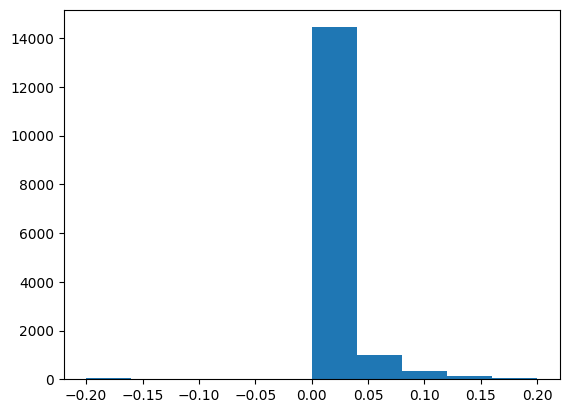

In [568]:
plt.hist(internal_diffs.to('cpu'), range=(-0.2,0.2))
plt.show()

In [525]:
get_nodes_from_segments(S, Vj.indices())

tensor(indices=tensor([[9335, 9335, 9336],
                       [9335, 9336, 9336]]),
       values=tensor([1., 1., 1.]),
       device='cuda:0', size=(16384, 16384), nnz=3, dtype=torch.float64,
       layout=torch.sparse_coo)

(array([9.4926e+04, 4.0000e+00, 8.0000e+00, 0.0000e+00, 0.0000e+00,
        8.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.5880e+03]),
 array([3.47074946e-16, 2.19011751e+36, 4.38023502e+36, 6.57035253e+36,
        8.76047005e+36, 1.09505876e+37, 1.31407051e+37, 1.53308226e+37,
        1.75209401e+37, 1.97110576e+37, 2.19011751e+37]),
 <BarContainer object of 10 artists>)

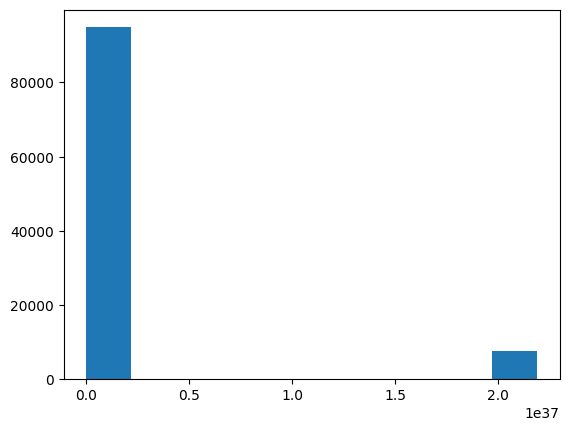

In [595]:
ps = S.values().to('cpu')
plt.hist(ps)

In [564]:
segment_size[(segment_size>0)]

tensor([1.4157e-10, 4.2924e-11, 5.9625e-10, 6.7535e-11, 2.6631e-10, 3.3200e-11,
        6.4618e-15, 2.0933e-10, 2.8158e+53, 1.1279e-09, 1.1361e-10, 1.6734e-11,
        3.8808e-11, 5.8664e-10, 3.1322e-11, 1.7628e-10, 8.6373e-12, 8.0792e-11,
        2.7066e-11, 7.3976e-10, 4.7415e-12, 2.8672e-12, 4.1375e-10, 6.2077e-12,
        2.8473e-11, 2.3219e-10, 4.5240e-11, 4.1539e-11, 7.7676e-12, 2.8482e-11,
        2.7112e-11, 3.3973e-10, 6.6673e-12, 7.2059e-10, 6.1309e-11, 1.6535e-10,
        9.2982e-10, 1.7015e-12, 1.1187e-11, 7.2045e-10, 6.8737e-11, 8.9741e-10,
        4.7974e-10, 1.1511e-10, 7.3068e-12, 2.1493e-10, 4.7177e-10, 5.6186e-10,
        5.9783e-10, 4.9629e-10, 6.2215e-12, 2.8157e+53, 1.4586e-10, 6.6303e-12,
        5.4808e-10, 2.7852e+53, 4.1398e-10, 1.5324e-09, 3.7225e-11, 1.9092e-10,
        2.8156e+53, 2.2388e-11, 1.1372e-10, 2.0865e-10, 3.0647e-10, 1.0907e-09,
        1.8739e-10, 1.6183e-10, 1.1867e-10, 9.5248e-10, 3.3568e-11, 4.2609e-10,
        1.9361e-11, 4.1287e-11, 6.0774e-

In [541]:
def to_segments(S, width, height):
    Sd = S.to_dense()
    return torch.argmax(Sd, dim=1).numpy().reshape(width, height)

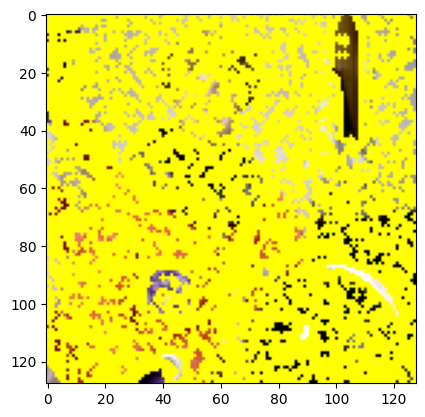

In [594]:
width, height, _ = img.shape
segments = to_segments(S.to('cpu'), width, height)

plt.imshow(mark_boundaries(img, segments))

In [563]:
segments

array([[8548, 8548, 8548, ..., 8548, 8548, 8548],
       [8548, 8548, 8548, ..., 8548, 8548, 8548],
       [8548, 8548, 8548, ..., 8548, 8548, 8548],
       ...,
       [8548, 8548, 8548, ..., 8548, 8548, 8548],
       [8548, 8548, 8548, ..., 8548, 8548, 8548],
       [8548, 8548, 8548, ..., 8548, 8548, 8548]])